# 8075 - Análise Multivariada

## Neste trabalho iremos utilizar os métodos Análise de Componentes Principais e Análise Fatorial.

O conjunto de dados utilizado é conhecido como [Breast Cancer Wisconsin](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data) e contém características calculadas a partir da digitalização de imagens massa mamária aspirate por agulhas finas (*fine needle aspirate*). Essas características descrevem o núcleo da célula presente na imagem.


Esse conjunto de dados foi utilizado originalmente no artigo ["Robust Linear Programming Discrimination of Two Linearly Inseparable Sets"](https://www.tandfonline.com/doi/abs/10.1080/10556789208805504) dos autores K. P. Bennett e O. L. Mangasarian, e foi publicado na revista "*Optimization Methods and Software*" em 1992.

O conjunto de dados contém um número de identificação de cada observação, uma diagnóstico (maligno (M) ou beningo (B)) e dez variáveis com valores númericos calculados para cada núcleo da células:

* radius (média das distâncias do centro aos pontos do perímetro)
* texture (desvio padrão dos valores em escala de cinza)
* perimeter
* area
* smoothness (variação local em comprimentos de raio)
* compactness ($\frac{perimeter^2}{area} - 1$)
* concavity (severidade das porções côncavas do contorno)
* concave points (número de porções côncavas do contorno)
* symmetry
* fractal dimension

Para cada uma destas 10 variáveis coletou-se a média, o erro padrão e o "pior" ou maior (média dos três maiores valores) dos valores para cada imagem, resultando em 30 variáveis.

## Análise Exploratória de Dados

In [42]:
# importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Vamos trabalhar apenas com a informação dos valores médios para cada uma das 10 colunas descritas anteriormente e o diagnóstico.

In [43]:
# importando os dados
df = pd.read_csv('/content/data.csv', usecols=['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean'])
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


Vamos verificar a quantidade de observações e variáveis do conjunto de dados.

In [44]:
print(f'O conjunto de dados possui {df.shape[0]} observações e {df.shape[1]} variáveis.')

O conjunto de dados possui 569 observações e 11 variáveis.


Vamos renomear as variáveis.

In [45]:
nomes = {'diagnosis':'diagnosis','radius_mean':'radius','texture_mean':'texture',
         'perimeter_mean':'perimeter','area_mean':'area','smoothness_mean':'smoothness',
         'compactness_mean':'compactness','concavity_mean':'concavity',
         'concave points_mean':'concave_points','symmetry_mean':'symmetry',
         'fractal_dimension_mean':'fractal_dimension'}

df.rename(columns=nomes, inplace=True)

Vamos verificar se há dados faltantes.

In [46]:
# verificando dados nulos
df.isnull().sum().sort_values()

diagnosis            0
radius               0
texture              0
perimeter            0
area                 0
smoothness           0
compactness          0
concavity            0
concave_points       0
symmetry             0
fractal_dimension    0
dtype: int64

Podemos observar que não há dados faltantes.

Vamos usar o método `info()` para ver como Python trata internamente cada variável e quantas observações não nulas há em cada variável.

In [47]:
# analisando tipos das variáveis
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   diagnosis          569 non-null    object 
 1   radius             569 non-null    float64
 2   texture            569 non-null    float64
 3   perimeter          569 non-null    float64
 4   area               569 non-null    float64
 5   smoothness         569 non-null    float64
 6   compactness        569 non-null    float64
 7   concavity          569 non-null    float64
 8   concave_points     569 non-null    float64
 9   symmetry           569 non-null    float64
 10  fractal_dimension  569 non-null    float64
dtypes: float64(10), object(1)
memory usage: 49.0+ KB


Podemos notar que a variável `diagnosis` é do tipo `object`, isto é, contém texto, enquanto as demais são do tipo inteiro ou contínuo.

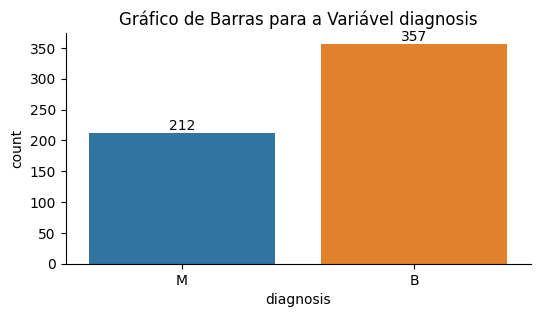

In [48]:
plt.figure(figsize=(6,3))
plt.title('Gráfico de Barras para a Variável diagnosis')
ax = sns.countplot(data=df, x='diagnosis')
sns.despine(left=False, bottom=False)
for label in ax.containers:
    ax.bar_label(label)

Podemos notar que a variável de interesse está desbalanceada, isso irá impor cuidado na hora de avaliar os modelos, pois algumas métricas podem ser influenciadas por esse desbalanço.

In [49]:
# calculando estatísticas descritivas
df.describe()

,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_points,symmetry,fractal_dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440


## Análise Univariada

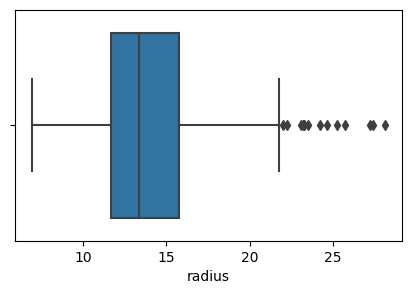

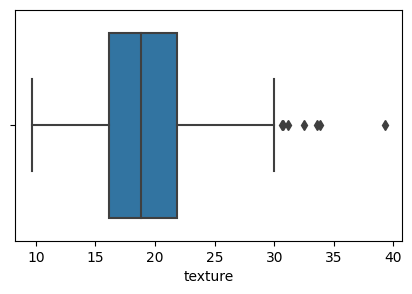

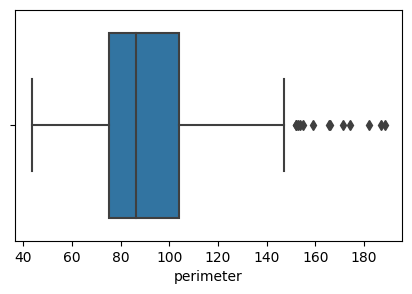

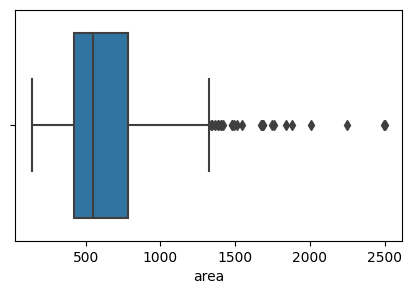

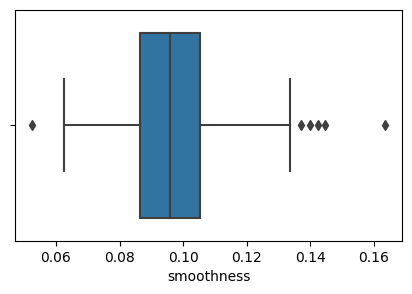

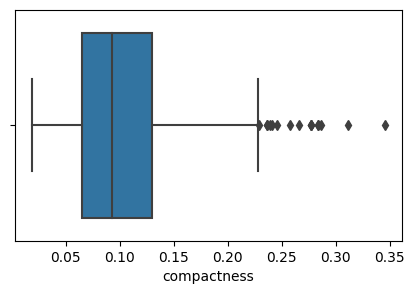

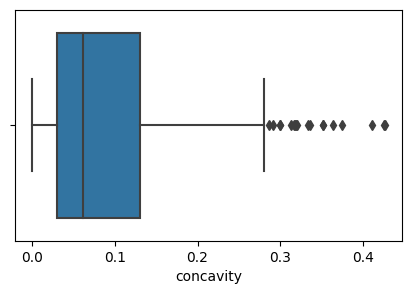

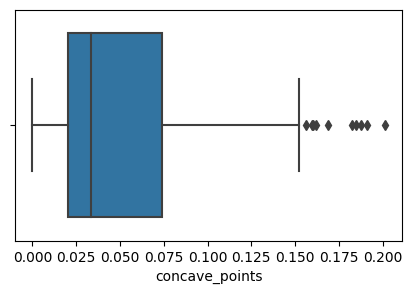

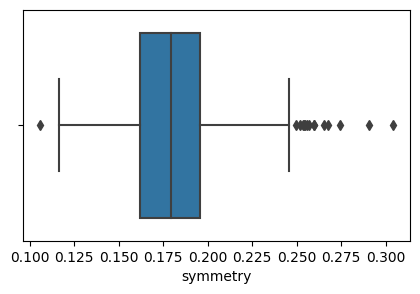

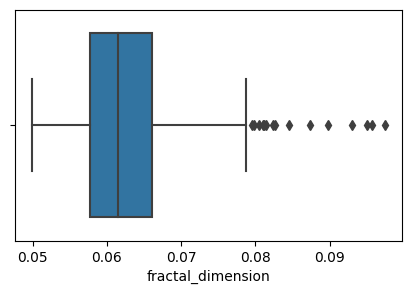

In [50]:
# boxplot para as colunas numéricas
for col in df.select_dtypes('float').columns:
    plt.figure(figsize=(5,3))
    sns.boxplot(df, x=col)
    plt.show()

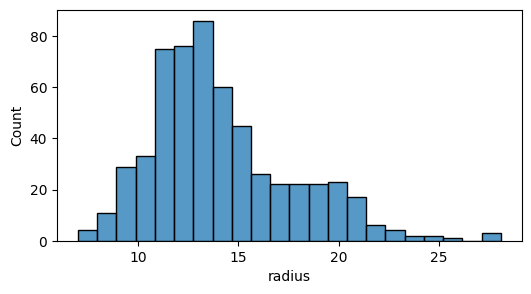

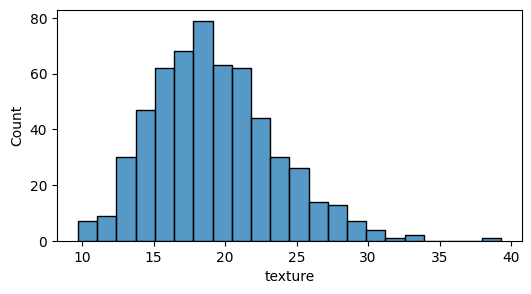

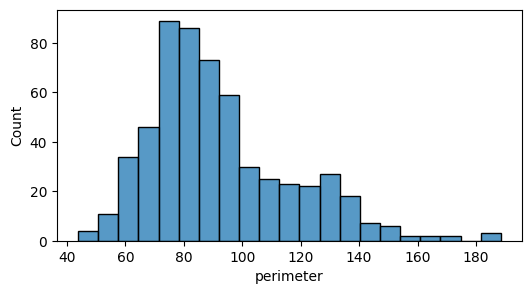

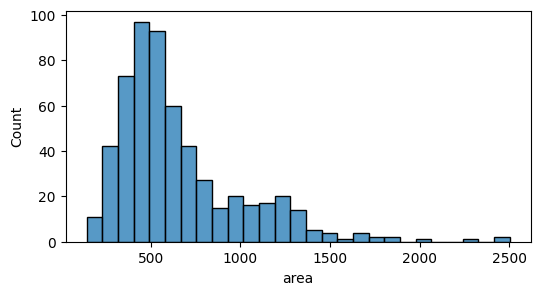

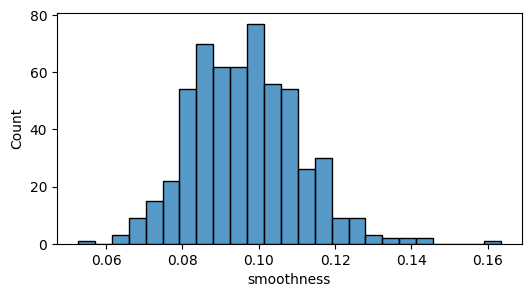

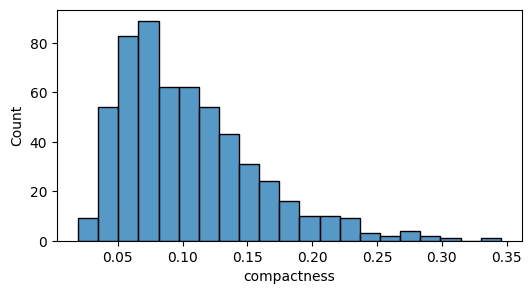

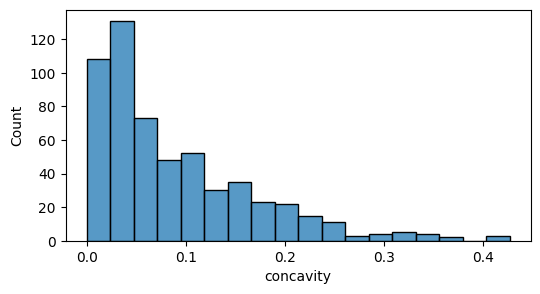

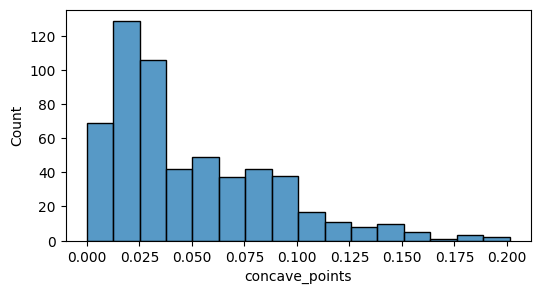

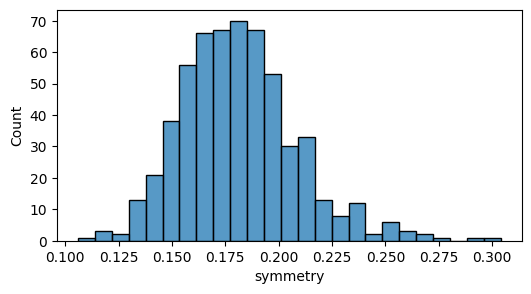

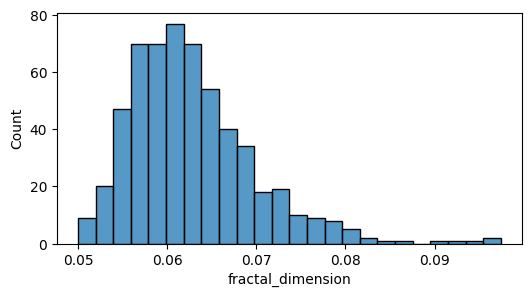

In [51]:
for col in df.select_dtypes(include='float64').columns:
    plt.figure(figsize=(6,3))
    sns.histplot(df, x=col)
    plt.show()

Todas as variáveis parecem apresentar outliers. Vamos identificar e remover estes valores pois o a Análise de Componentes Principais e a Análise Fatorial são sensíveis a outliers.

In [52]:
# função para remover outliers de acordo com o critério do boxplot
def remove_outliers(dados_numericos):

    mask = pd.Series([False for i in range(dados_numericos.shape[0])])
    for col in dados_numericos.columns:
        q1, q3 = dados_numericos[col].quantile([0.25,0.75])
        IQR = q3 - q1
        min = q1 - 1.5 * IQR
        max = q3 + 1.5 * IQR
        mask_aux = (dados_numericos[col] < min) | (dados_numericos[col] > max)
        mask = mask + mask_aux

    mask_ouliers = [not i for i in mask]
    return mask_ouliers

In [53]:
mask_outliers = remove_outliers(df.iloc[:,1:])
dados = df[mask_outliers].reset_index(drop=True)
dados.head()

,diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_points,symmetry,fractal_dimension
0,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
1,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
2,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883
3,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,0.2087,0.07613
4,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.1127,0.07400,0.1794,0.05742


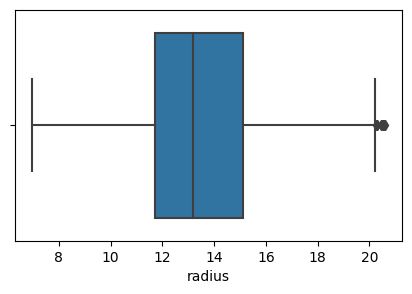

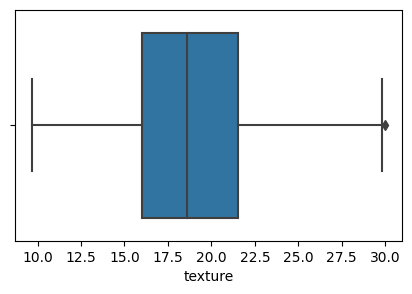

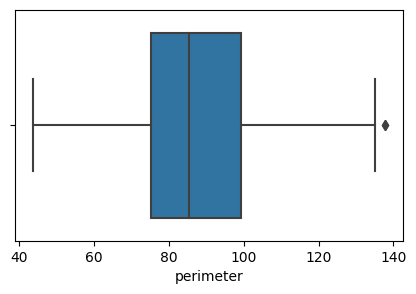

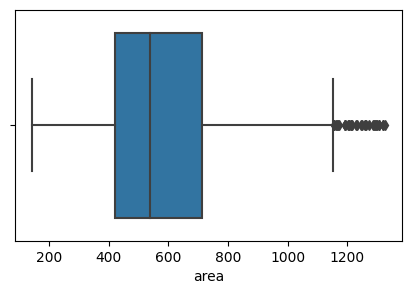

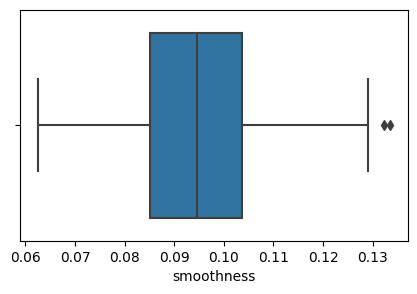

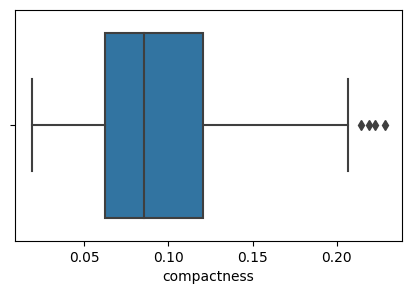

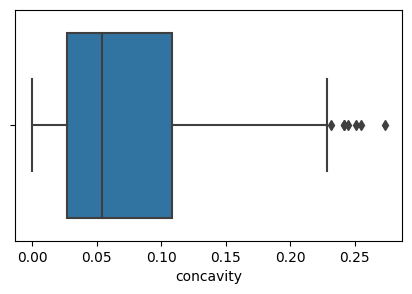

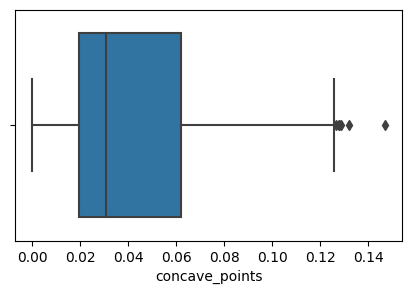

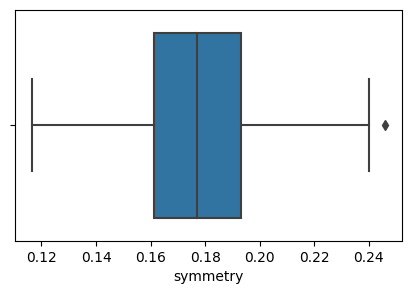

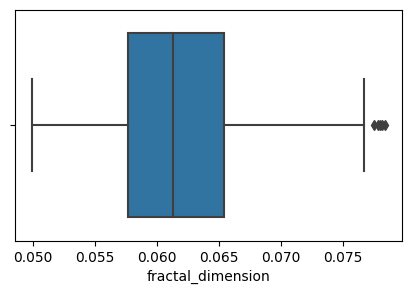

In [54]:
# boxplot para as colunas numéricas
for col in dados.select_dtypes('float').columns:
    plt.figure(figsize=(5,3))
    sns.boxplot(dados, x=col)
    plt.show()

In [55]:
print(f'Os dados originais tinham {df.shape[0]} observações.')
print(f'Os dados sem outliers tem {dados.shape[0]} observações.')

Os dados originais tinham 569 observações.
Os dados sem outliers tem 502 observações.


Podemos notar que o problema de outliers foi praticamente resolvido, pois os pontos que aparentam ser outliers nos boxplots são apenas ligeiramente maiores que o valor limite e não vamos retirá-los para não deixar a amostra muito pequena.

## Análise Bivariada

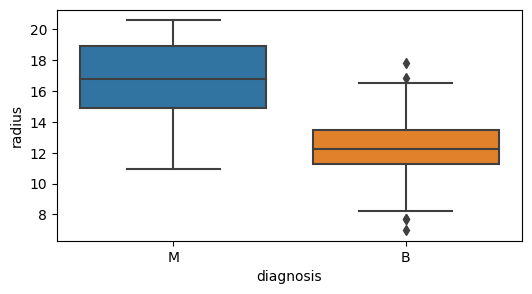

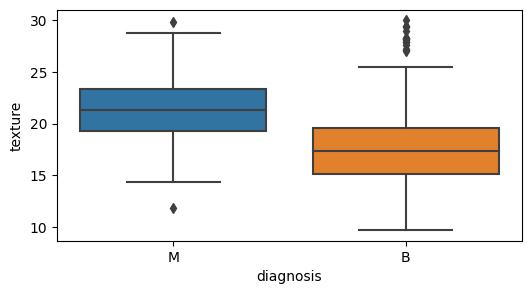

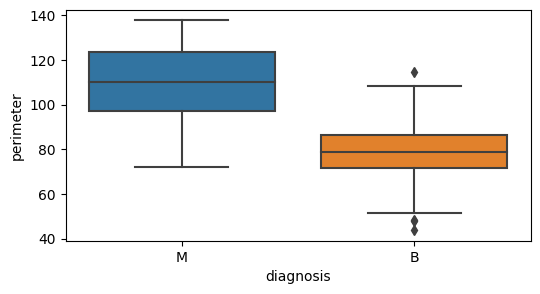

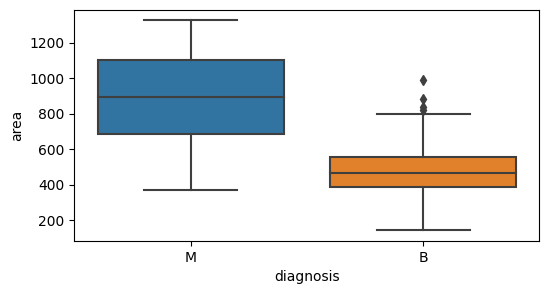

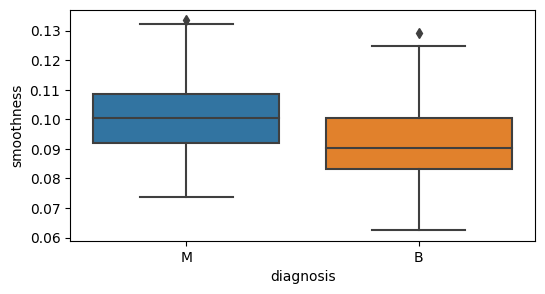

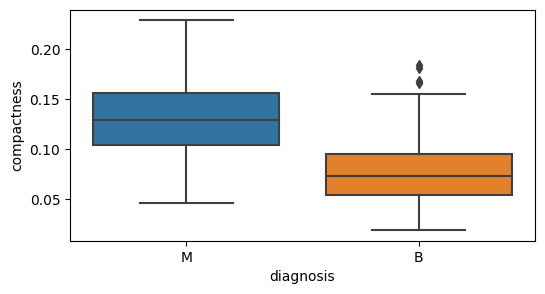

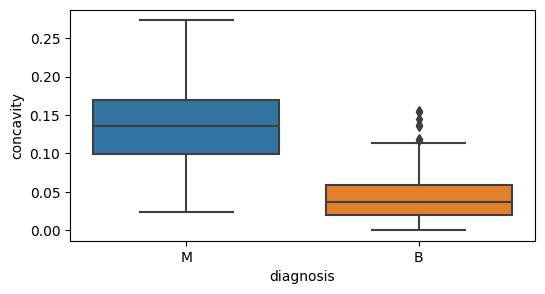

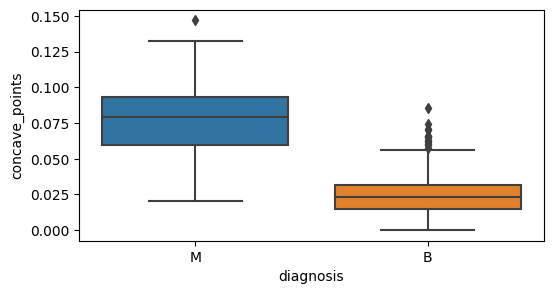

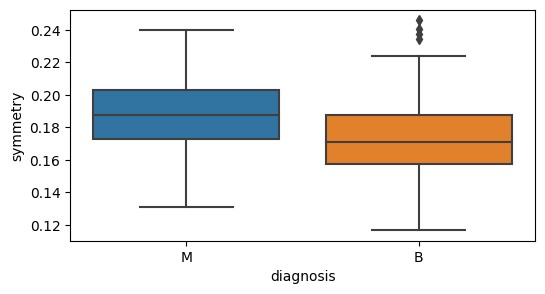

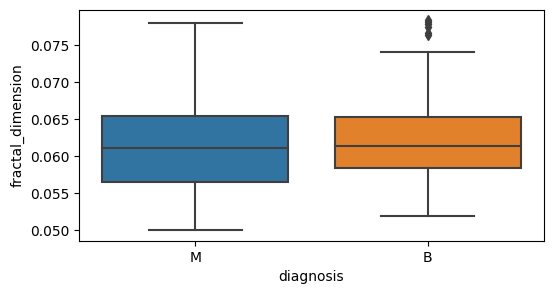

In [56]:
for col in dados.select_dtypes(include='float').columns:
    plt.figure(figsize=(6,3))
    sns.boxplot(dados, x='diagnosis', y=col)
    plt.show()

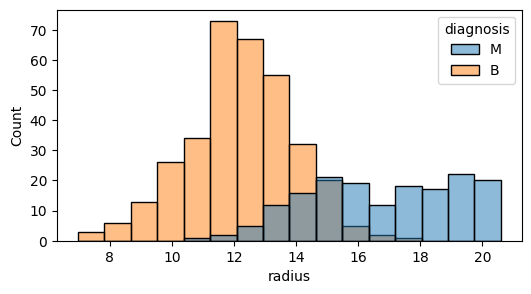

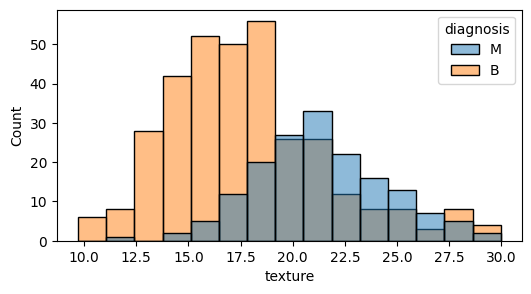

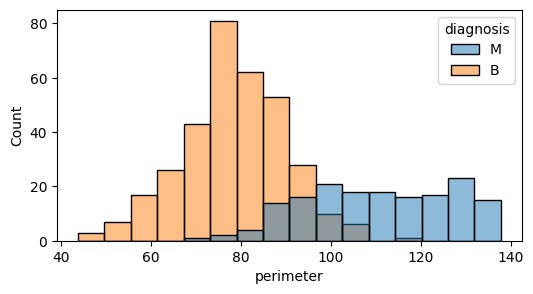

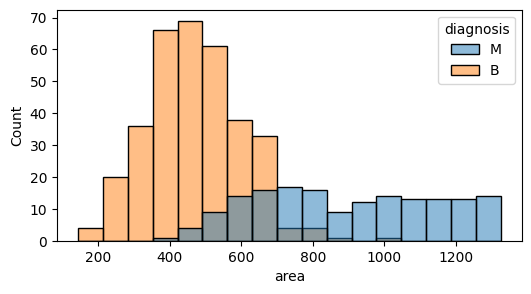

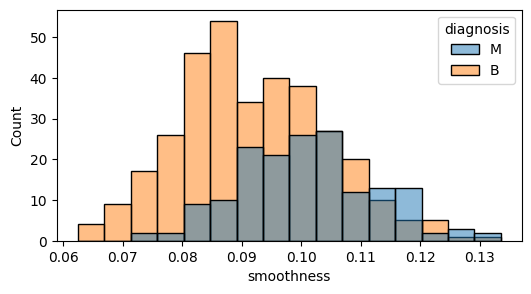

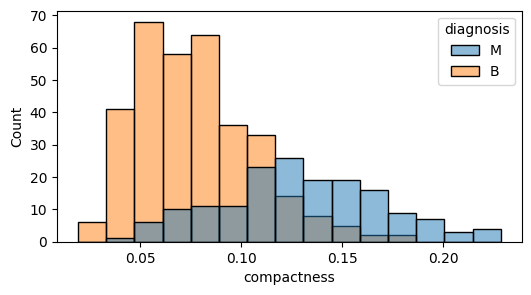

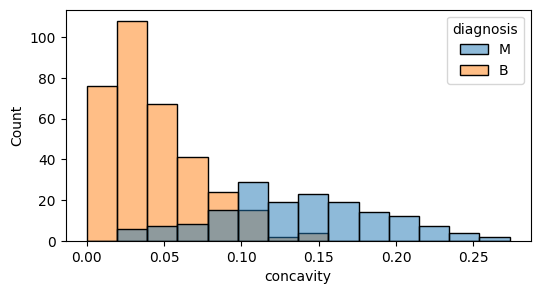

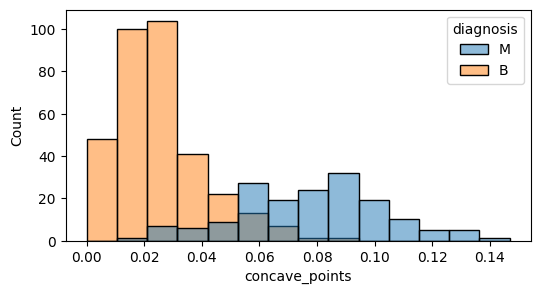

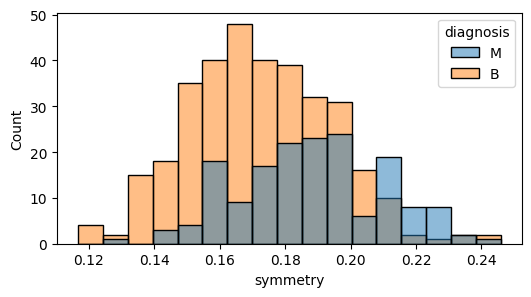

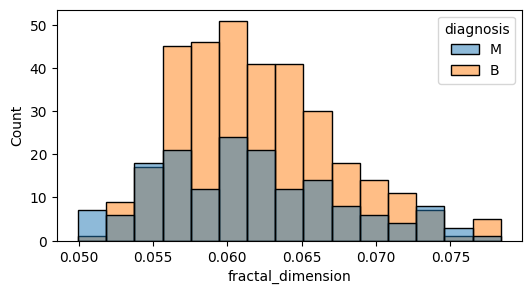

In [57]:
for col in dados.select_dtypes(include='float').columns:
    plt.figure(figsize=(6,3))
    sns.histplot(dados, x = col, hue='diagnosis')
    plt.show()

Pela comparação dos gráficos podemos ver que todas as variáveis, com exceção de fractal_dimension, são maiores para a classe M em comparação com a classe B.

Vamos aplicar testes de hipótese para a média dos dois grupos para ver se são estatisticamente distintos.


Dica: Para realizar o teste t para duas amostra independentes pode-se usar a função `scipy.stats.ttest_ind()` passando os dois grupos como argumentos. Esta função retornará dois valores: o valor t calculado e o p-valor.

In [58]:
from scipy.stats import ttest_ind

for coluna in dados.columns[1:]:
    estat, pvalor = ttest_ind(dados[coluna][dados['diagnosis'] == 'M'],
                              dados[coluna][dados['diagnosis'] == 'B'])

    print(f'Para a variável {coluna} o p-valor é {pvalor}')

Para a variável radius o p-valor é 5.885498179018834e-86
Para a variável texture o p-valor é 1.6201265103805142e-22
Para a variável perimeter o p-valor é 2.879028374725117e-91
Para a variável area o p-valor é 1.3571955959504553e-89
Para a variável smoothness o p-valor é 3.4409439932156506e-14
Para a variável compactness o p-valor é 3.8658357780003457e-50
Para a variável concavity o p-valor é 1.9172073957933418e-92
Para a variável concave_points o p-valor é 2.5674825425526535e-109
Para a variável symmetry o p-valor é 9.577897665565718e-14
Para a variável fractal_dimension o p-valor é 0.28618412302574764


Podemos ver que, com exceção da variável `fractal_dimension` todas as demais apresentam um p-valor menor que 0.01, ou seja, com 99% de confiança podemos dizer que as médias das variáveis são distintas.

### Correlação

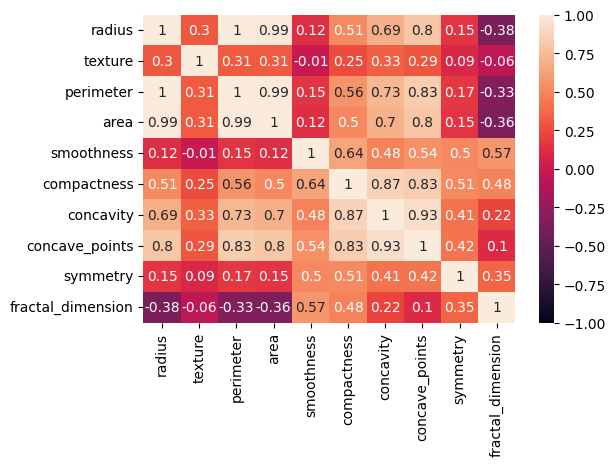

In [59]:
# calculando correlação entre as variáveis
plt.figure(figsize=(6,4))
sns.heatmap(dados.corr(method='pearson', numeric_only=True).round(2),
            vmin=-1, vmax=1, annot=True);

Podemos notar que as variáveis `area`, `perimeter` e `radius` são fortemente correlacionadas e isso é natural pois o cálculo da área e perímetro envolve o raio. Algumas outras variáveis também apresentam correlação moderada. Vamos remover essas variáveis altamente correlacionadas para realizar o PCA, pois estas impactam na interpretação do mesmo. Para mais informações clique [aqui](https://stats.stackexchange.com/questions/50537/should-one-remove-highly-correlated-variables-before-doing-pca).

In [60]:
dados_pca = dados.drop(['area','perimeter','concavity'], axis=1)

# Análise de Componentes Principais

Análise de Componentes Principais é uma técnica de redução de dimensionalidade que pode ser utilizada para extrair informação de um espaço de alta dimensão e projetá-la em um espaço de baixa dimensão, preservando as partes essenciais que apresentam maior variação e removendo as que tem menor variação.

Os componentes principais são vetores ortogonais que estão associados com as direções de mais variabilidade dos dados. A primeira componente aponta na direção de maior variabilidade, a segunda componente aponta na segunda direção de maior variabilidade que é ortogonal à primeira e assim sucessivamente.

Vamos observar nossos dados.

In [61]:
dados_pca.head()

,diagnosis,radius,texture,smoothness,compactness,concave_points,symmetry,fractal_dimension
0,M,20.57,17.77,0.08474,0.07864,0.07017,0.1812,0.05667
1,M,19.69,21.25,0.10960,0.15990,0.12790,0.2069,0.05999
2,M,20.29,14.34,0.10030,0.13280,0.10430,0.1809,0.05883
3,M,12.45,15.70,0.12780,0.17000,0.08089,0.2087,0.07613
4,M,18.25,19.98,0.09463,0.10900,0.07400,0.1794,0.05742


Observando os dados é possível notar que as variáveis possuem escalas diferentes e isso afeta o cálculo do PCA, portanto vamos mudar a escala das variáveis. Para isso vamos usar o `MinMaxScaler`do `scikit-learn`.

In [62]:
from sklearn.preprocessing import MinMaxScaler

# escalonando os dados
dados_scaled = MinMaxScaler().fit_transform(dados_pca.iloc[:, 1:])
dados_scaled = pd.DataFrame(dados_scaled)
dados_scaled.columns = dados_pca.columns[1:]
dados_scaled.head()

,radius,texture,smoothness,compactness,concave_points,symmetry,fractal_dimension
0,0.998530,0.397828,0.313143,0.283514,0.477672,0.499226,0.236018
1,0.933867,0.569595,0.663333,0.672280,0.870660,0.698142,0.352796
2,0.977956,0.228529,0.532328,0.542627,0.710007,0.496904,0.311994
3,0.401866,0.295656,0.919707,0.720601,0.550647,0.712074,0.920507
4,0.828055,0.506910,0.452458,0.428763,0.503744,0.485294,0.262399


Agora vamos usar o `PCA` também do `scikit-learn`. Podemos passar para o `PCA()` quanta variabilidade queremos capturar com o parâmetro `n_components` e ele retornará a quantidade de componentes que juntas apresentam pelo menos o valor especificado de variabilidade ou podemos passar um número inteiro que retornará a quantidade de componentes indicada.

Se nenhum valor for especificado ele retornará o número de componentes igual ao número de variáveis.

In [63]:
from sklearn.decomposition import PCA

# aplicando PCA
pca_breast = PCA()
componentes = pca_breast.fit_transform(dados_scaled)
pca_breast_df = pd.DataFrame(data=componentes)
pca_breast_df.head()

,0,1,2,3,4,5,6
0,0.188090,-0.460546,-0.221542,0.064802,-0.080445,0.201194,-0.067538
1,0.808199,-0.239979,-0.119738,0.063662,0.036031,0.025883,0.097542
2,0.495418,-0.284360,-0.419162,-0.059478,-0.044700,0.075888,0.016450
3,0.573621,0.639109,-0.117414,-0.071270,0.031888,0.012683,0.028257
4,0.276045,-0.318713,-0.094439,0.009792,0.005847,0.040171,-0.016274


Podemos observar todas as componentes com o atributo `components_`.

In [64]:
# componentes
pca_breast.components_

array([[ 0.40643853,  0.19221688,  0.34033296,  0.50828256,  0.55790695,
         0.28848465,  0.17087759],
       [-0.5406625 , -0.2603596 ,  0.35846887,  0.12973834, -0.16973879,
         0.23176564,  0.64190217],
       [-0.23209349,  0.93131282, -0.11815391,  0.00991499, -0.15720383,
         0.01420609,  0.19953828],
       [-0.04443267,  0.01439001, -0.07362009, -0.20532138, -0.11899972,
         0.91609474, -0.31120955],
       [-0.08085188,  0.16559304,  0.83168925, -0.37701752,  0.0119064 ,
        -0.13698008, -0.33658193],
       [ 0.41694086,  0.01406183, -0.05117556, -0.70282121,  0.16178783,
         0.06513251,  0.54678007],
       [-0.55341976, -0.00980372, -0.2048593 , -0.2155499 ,  0.77119228,
        -0.02498263, -0.09919528]])

Podemos observar a variância explicada por cada componente com o atributo `explained_variance_`.

In [65]:
print(pca_breast.explained_variance_)

[0.12862438 0.07114373 0.03334702 0.0198042  0.0112007  0.00344203
 0.00283685]


Podemos observar a variância percentual explicada por cada componente com o atributo `explained_variance_ratio_`.

In [66]:
print(f'Variância percentual explicada por cada componente: {pca_breast.explained_variance_ratio_.round(2)}')

Variância percentual explicada por cada componente: [0.48 0.26 0.12 0.07 0.04 0.01 0.01]


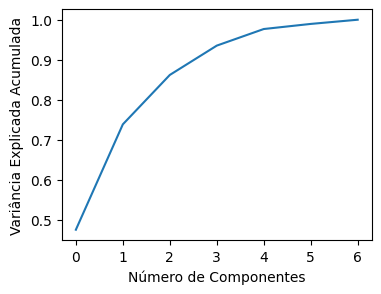

In [67]:
pca_breast = PCA().fit(dados_scaled)
plt.figure(figsize=(4,3))
plt.plot(np.cumsum(pca_breast.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada');

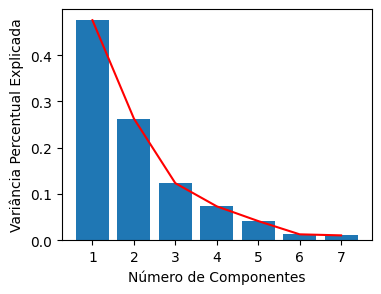

In [69]:
plt.figure(figsize=(4,3))
plt.bar(range(1, 8), pca_breast.explained_variance_ratio_)
plt.plot(range(1, 8), pca_breast.explained_variance_ratio_, c='red')
plt.xticks(range(1, 8))
plt.xlabel("Número de Componentes")
plt.ylabel("Variância Percentual Explicada")
plt.show()

Com base nestes valores poderíamos considerar apenas as 4 primeiras componentes, pois elas explicam cerca de 94% da variabilidade dos dados. Para fins de visualização vamos considerar somente duas componentes.

In [70]:
# aplicando PCA
pca_breast = PCA(n_components=2)
componentes = pca_breast.fit_transform(dados_scaled)
pca_breast_df = pd.DataFrame(data=componentes, columns=['comp1','comp2'])
pca_breast_df['diagnosis'] = dados_pca['diagnosis']
pca_breast_df.head()

,comp1,comp2,diagnosis
0,0.188090,-0.460546,M
1,0.808199,-0.239979,M
2,0.495418,-0.284360,M
3,0.573621,0.639109,M
4,0.276045,-0.318713,M


Podemos observar também os valores singulares (autovalores) de cada componente com o atributo `singular_values_`.

In [71]:
pca_breast.singular_values_

array([8.02750362, 5.97017668])

In [72]:
print(f'Variância percentual explicada por cada componente: {pca_breast.explained_variance_ratio_.round(2)}')

Variância percentual explicada por cada componente: [0.48 0.26]


Podemos ver que a primeira componente explica cerca de 47% da variabilidade enquanto a segunda componente explica cerca de 26% e assim sucessivamente. Juntas elas explicam cerca de 73%. Em outras palavras, estamos "perdendo" cerca de 27% da informação contida nos dados ao usar duas componentes.

Vamos plotar as observações nas duas componentes para ver como estas afetam as classes.

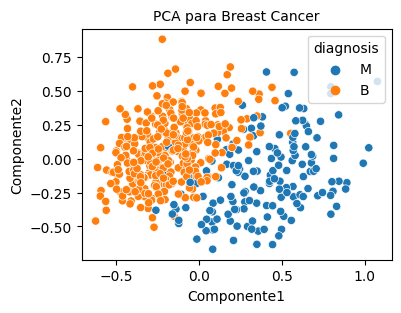

In [73]:
plt.figure(figsize=(4,3))
plt.xlabel('Componente1', fontsize=10)
plt.ylabel('Componente2',fontsize=10)
plt.title("PCA para Breast Cancer",fontsize=10)
sns.scatterplot(pca_breast_df, x='comp1', y='comp2', hue='diagnosis');

Do gráfico acima podemos observar que as classes `M` e `B` projetadas no espaço de duas dimensões são de certa forma separáveis.

Podemos ter uma ideia da variabilidade explicada de acordo com o número de variáveis no gráfico abaixo.

In [74]:
# criação de variáveis auxiliares
PC1 = componentes[:,0]
PC2 = componentes[:,1]
scalePC1 = 1.0/(PC1.max() - PC1.min())
scalePC2 = 1.0/(PC2.max() - PC2.min())

Vamos observar alguns biplots.

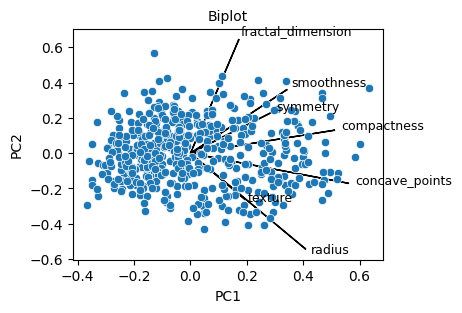

In [75]:
plt.figure(figsize=(4,3))

for i, feature in enumerate(dados_pca.columns[1:]):
    plt.arrow(0, 0, pca_breast.components_[0, i],
             pca_breast.components_[1, i])
    plt.text(pca_breast.components_[0, i] * 1.05,
            pca_breast.components_[1, i] * 1.05,
            feature, fontsize=9)

sns.scatterplot(x=PC1 * scalePC1, y=PC2 * scalePC2)

plt.xlabel('PC1', fontsize=10)
plt.ylabel('PC2', fontsize=10)
plt.title('Biplot', fontsize=10);

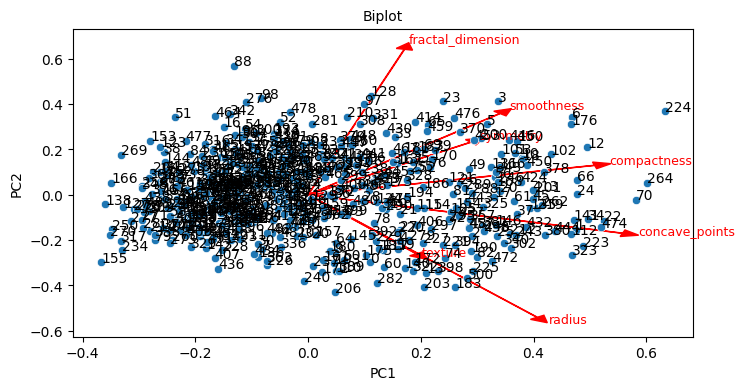

In [76]:
plt.figure(figsize=(8,4))

for i, feature in enumerate(dados_pca.columns[1:]):
    plt.arrow(0, 0, pca_breast.components_[0, i],
             pca_breast.components_[1, i],
            color="red", head_width=0.03, head_length=0.03)
    plt.text(pca_breast.components_[0, i] * 1.05,
            pca_breast.components_[1, i] * 1.05,
            feature, color="red", fontsize=9)

sns.scatterplot(x=PC1 * scalePC1, y=PC2 * scalePC2)

plt.xlabel('PC1', fontsize=10)
plt.ylabel('PC2', fontsize=10)
plt.title('Biplot', fontsize=10)

for i, label in enumerate(pca_breast_df.index):
    plt.text(PC1[i] * scalePC1,
            PC2[i] * scalePC2, str(label),
            fontsize=10)

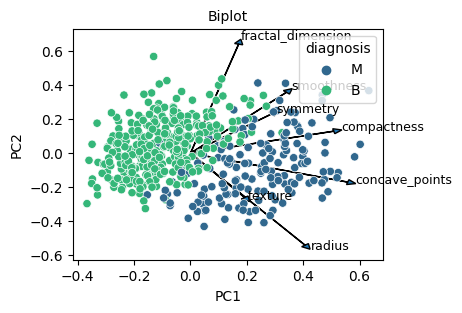

In [77]:
plt.figure(figsize=(4,3))

for i, feature in enumerate(dados_pca.columns[1:]):
    plt.arrow(0, 0, pca_breast.components_[0, i],
             pca_breast.components_[1, i],
             head_width=0.03, head_length=0.03)
    plt.text(pca_breast.components_[0, i] * 1.05,
            pca_breast.components_[1, i] * 1.05,
            feature, fontsize=9)

sns.scatterplot(x=PC1 * scalePC1,
                y=PC2 * scalePC2,
                hue=pca_breast_df['diagnosis'],
                palette="viridis")

plt.xlabel('PC1', fontsize=10)
plt.ylabel('PC2', fontsize=10)
plt.title('Biplot', fontsize=10);

In [78]:
pca_breast.explained_variance_ratio_

array([0.4756838 , 0.26310658])

# Análise Fatorial

Resumidamente, a análise fatorial consiste em identificar quantos fatores latentes estão influenciando a variabilidade de um conjunto de variáveis correlacionadas, com a vantagem de podermos trabalhar com os fatores ao invés dos dados originais, servindo como uma técnica de redução de dimensionalidade ou uma técnica de seleção de variáveis.

Todas as variáveis de um conjunto de dados terão alguma correlação com as demais, e a análise fatorial agrupa o conjunto de variáveis, chamados fatores, que tenham alta correlação entre si e pouca correlação com as demais de modo a se minimizar a perda de informação que os fatores carregam em relação aos dados originais.

A análise fatorial baseia-se na variância das variáveis para encontrar os fatores. Mais especificamente, a variância de cada variável pode ser decomposta como uma soma de três variâncias:

* Variância Comum: variância que cada variável compartilha com as demais.

* Variância Específica: variância que uma variável compartilha com uma outra variável específica.

* Variância Erro: variância que não pode ser explicada por correlações com outras variáveis.

## Pressupostos da Análise Fatorial

A análise fatorial assume os seguintes pressupostos:

* Variáveis correlacionadas;

* Uso apenas de variáveis quantitativas contínuas;

* Existência de mais observações que variáveis;

* Dados sem outliers.


Para testar se as variáveis estão correlacionadas, usaremos o **teste de Bartlett**. Neste teste a hipótese nula é que matriz de correlação da população é uma matriz identidade, ou seja, as variáveis não são correlacionadas.

Primeiro vamos escalonar os dados.

In [79]:
from sklearn.preprocessing import MinMaxScaler

# escalonando os dados
dados_scaled = MinMaxScaler().fit_transform(dados.iloc[:, 1:])
dados_scaled = pd.DataFrame(dados_scaled)
dados_scaled.columns = dados.columns[1:]
dados_scaled.head()

,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_points,symmetry,fractal_dimension
0,0.998530,0.397828,0.947878,1.000000,0.313143,0.283514,0.317966,0.477672,0.499226,0.236018
1,0.933867,0.569595,0.917030,0.895983,0.663333,0.672280,0.722283,0.870660,0.698142,0.352796
2,0.977956,0.228529,0.971280,0.975476,0.532328,0.542627,0.724479,0.710007,0.496904,0.311994
3,0.401866,0.295656,0.412509,0.282114,0.919707,0.720601,0.577387,0.550647,0.712074,0.920507
4,0.828055,0.506910,0.806404,0.758140,0.452458,0.428763,0.412367,0.503744,0.485294,0.262399


## Teste de Bartlett

A matriz de correlação sugere que a hipótese nula não é verdadeira, iremos tentar confirmar essi com um teste de hipótese.

Para realizar esse teste em `Python` usaremos a função `calculate_bartlett_sphericity` do pacote `factor_analyzer`.

Está função retornará para nós dois valores: a estatística qui quadrado do teste e o p-valor. Consideraremos um nível de significância de 5%.


In [80]:
!pip install factor_analyzer -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 1.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 23.4 MB/s eta 0:00:00


In [81]:
# importando a funcao e realizando o teste
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square, p_valor = calculate_bartlett_sphericity(dados_scaled)
print(f"A estatística do teste é {chi_square} e seu respectivo p-valor é {p_valor}")

A estatística do teste é 9905.505384063377 e seu respectivo p-valor é 0.0


Como o p valor é menor que 0.05 podemos rejeitar a hipótese nula, isto é, temos 95% de confiança de que há correlação entre as variáveis. Sendo assim, vamos continuar com a análise fatorial.

### Medida de Kaiser-Meyer-Olkin (KMO)

A medida de Kaiser-Meyer-Olkin (KMO) compara as grandezas dos coeficientes de correlação observados com as grandezas dos coeficientes de correlação parcial.

Valores baixos de KMO indicam que as correlações entre os pares de variáveis não podem ser explicadas por outras variáveis, indicando que a análise fatorial não é adequada. Como o KMO varia entre 0 e 1, vamos proceder com a análise fatorial se o KMO for próximo de 1.


In [82]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all, kmo_model = calculate_kmo(dados_scaled)
kmo_model

/usr/local/lib/python3.10/dist-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.7877843654499069

Como o valor é relativamente alto, vamos continuar com a análise fatorial.

Para realizar a Análise Fatorial vamos:

* Encontrar a quantidade ideal de fatores;

* Rotacionar os fatores para facilitar suas interpretações.

A quantidade ideal de fatores pode ser obtida da análise dos autovalores da matriz de cargas fatoriais. O fator será considerado relevante se o seu autovalor for maior que 1.

In [83]:
# importando a função FactorAnalyzer
from factor_analyzer import FactorAnalyzer

# criando um objeto para fazer análise fatorial
fa = FactorAnalyzer(rotation=None)

# aplicando a análise fatorial aos dados
fa.fit(dados_scaled)

# obtendo os autovalores
autovalores, autovetores = fa.get_eigenvalues()
autovalores

array([5.37078759e+00, 2.46273555e+00, 8.93495943e-01, 6.27077441e-01,
       3.54144292e-01, 1.56245963e-01, 9.05878137e-02, 3.74735764e-02,
       7.23389732e-03, 2.17933197e-04])

Temos somente 2 autovalores maiores que 1, ou seja, 2 fatores. Podemos visualizar os autovalores com um scree plot.

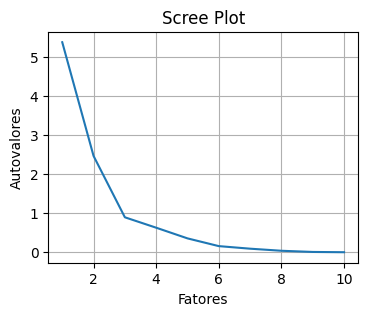

In [84]:
# Criando um scree plot
plt.figure(figsize=(4,3))
sns.lineplot(x=range(1, dados_scaled.shape[1]+1), y=autovalores)
plt.title('Scree Plot')
plt.xlabel('Fatores')
plt.ylabel('Autovalores')
plt.grid();

Agora, vamos calcular a variância explicada por cada fator e a variância explicada cumulativa.

In [85]:
# criando um objeto para fazer análise fatorial com 2 fatores
fa = FactorAnalyzer(n_factors=2, rotation=None)
fa.fit(dados_scaled)

# criando nome para as colunas do DataFrame de cargas fatoriais
colunas = ['Fator '+str(i) for i in range(2)]

# criando DataFrame para a variância
variancia_fator = pd.DataFrame(fa.get_factor_variance(),
                   index=['Variância','Variância Proporcional','Variância Acumulada'],
                   columns=colunas)

variancia_fator

,Fator 0,Fator 1
Variância,5.267361,2.220134
Variância Proporcional,0.526736,0.222013
Variância Acumulada,0.526736,0.748750


Vemos assim que os 2 fatores podem explicar cerca de 74,9% da variabilidade total dos dados.

### Comunalidades

Comunalidade é a proporção da variância de cada variável que pode ser explicada pelos fatores. A rotação não tem influência nas comunalidades.

In [86]:
pd.DataFrame(fa.get_communalities(),
             index=dados_scaled.columns,
             columns=['Comunalidades'])

,Comunalidades
radius,0.989291
texture,0.108694
perimeter,0.993612
area,0.976641
smoothness,0.595357
compactness,0.908897
concavity,0.870826
concave_points,0.950199
symmetry,0.322004
fractal_dimension,0.771972


Podemos considerar que 90,9% da variância da variável `compactness` é explicada pelos dois fatores.

### Rotação

Vamos rotacionar os dois fatores para ter uma melhor interpretação destes. A rotação tende a representar os fatores de forma não correlacionada e, por isso, facilita sua interpretação.

Há vários métodos de rotação, vamos usar o método Varimax.

In [87]:
# realizando a análise fatorial com rotação
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(dados_scaled)

# criando DataFrame de cargas fatoriais
cargas_fat = pd.DataFrame(fa.loadings_,
                          index=dados_scaled.columns,
                          columns=colunas)
cargas_fat

,Fator 0,Fator 1
radius,0.994538,0.013643
texture,0.321939,0.071059
perimeter,0.994521,0.067388
area,0.987988,0.022834
smoothness,0.089257,0.766414
compactness,0.496433,0.813911
concavity,0.705879,0.610378
concave_points,0.800151,0.556738
symmetry,0.139569,0.550022
fractal_dimension,-0.386336,0.789124


As cargas fatoriais indicam quanto um fator explica uma variável. Esses valores variam de -1 a 1 e quanto mais próximo desses valores, mais o fator explica a variável.

Vamos estabelecer o valor de corte de 0,7 para entender quais fatores explicam quais variáveis.

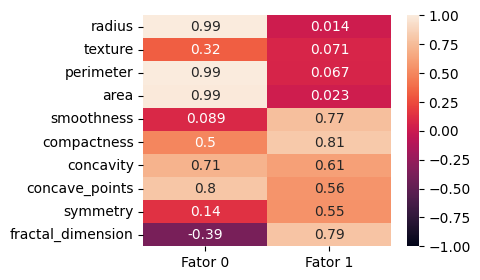

In [88]:
# observando o valor das cargas fatoriais com heatmap
plt.figure(figsize=(4,3))
sns.heatmap(cargas_fat, vmin=-1, vmax=1, annot=True);

In [89]:
# criando o dicionário
fatores_variaveis = {}

# preenchendo o dicionário
for i in range(2):
  fatores_variaveis['Fator '+str(i)] = cargas_fat[cargas_fat.iloc[:,i] > 0.7].iloc[:,i].index.tolist()

fatores_variaveis

{'Fator 0': ['radius', 'perimeter', 'area', 'concavity', 'concave_points'],
 'Fator 1': ['smoothness', 'compactness', 'fractal_dimension']}

O fator 0 explica as variáveis `radius`,`perimeter`,`area`, `concavity` e `concave_points` enquanto o fator 1 explica as variáveis `smoothness`,`compactness` e `fractal_dimension`.

Podemos notar que o `Fator 0` agrupa as variáveis de alta correlação que comentamos ao analisar a matriz de correlação.